In [ ]:
!pip install hampel

import numpy as np
import pandas as pd
import re
from math import sqrt
from hampel import hampel
from scipy.signal import savgol_filter
import os
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 2.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hampel: filename=hampel-1.0.2-cp312-cp312-linux_x86_64.whl size=249571 sha256=b4e380164a2552e7863a8c05dac168fa5629dcf23f40672c39a1be25755d23e1
  Stored in directory: /root/.cache/pip/wheels/26/b7/c0/993b6604f8a9e7f3dd8753e663ce7bafaf0215c4bfec111100
Successfully built hampel


In [ ]:
import re
import pandas as pd
import numpy as np
from math import sqrt

def parse_csi_to_amplitude(csi_string):
    """
    Parsuje pojedynczą linię CSI (jako string) i zwraca listę amplitud.
    """
    try:
        csi_string_content = re.findall(r"\[(.*)\]", csi_string)[0]
        csi_raw = [int(x) for x in csi_string_content.split(" ") if x != '']
        imaginary = []
        real = []
        amplitudes = []
        for i in range(len(csi_raw)):
            if i % 2 == 0:
                imaginary.append(csi_raw[i])
            else:
                real.append(csi_raw[i])
        for i in range(len(real)):
            amplitudes.append(sqrt(imaginary[i] ** 2 + real[i] ** 2))
        return amplitudes
    except Exception as e:
        return None

# --- ZMIANA TUTAJ ---
# Zaktualizuj tę listę, aby zawierała Twoje 5 plików i etykiet
# Pamiętaj, aby wgrać te pliki do środowiska Colab!
files_to_process = [
    ('lezenie_merged.csv', 'lezenie'),
    ('siedzenie_merged.csv', 'siedzenie'),
    ('br_ak_merged.csv', 'brak aktywności'),
    ('wiercenie_się_test.csv', 'wiercenie się'),
    ('chodzenie_test.csv' , 'chodzenie')

    # Upewnij się, że nazwy plików są poprawne
]
# --- Koniec Zmiany ---

raw_amp_dataframes = []
label_list_files = []

for filepath, label in files_to_process:
    all_amplitudes_for_file = []
    try:
        with open(filepath, 'r') as f:
            for line in f:
                amps = parse_csi_to_amplitude(line)
                if amps:
                    all_amplitudes_for_file.append(amps)

        if all_amplitudes_for_file:
            temp_df = pd.DataFrame(all_amplitudes_for_file)
            raw_amp_dataframes.append(temp_df)
            label_list_files.append(label)
            print(f" Utworzono DataFrame o kształcie: {temp_df.shape} dla etykiety '{label}'")
        else:
            print(f" OSTRZEŻENIE: Nie znaleziono poprawnych danych CSI w pliku {filepath}.")

    except FileNotFoundError:
        print(f" BŁĄD: Nie znaleziono pliku {filepath}. Upewnij się, że został wgrany.")
    except Exception as e:
        print(f" BŁĄD: Wystąpił nieoczekiwany błąd przy pliku {filepath}: {e}")

print(f"\nŁączna liczba wczytanych plików (aktywności): {len(raw_amp_dataframes)}")
print(f"Etykiety dla wczytanych plików: {label_list_files}")

total_frames = 0
for i in range(len(raw_amp_dataframes)):
    label = label_list_files[i]
    frames_count = raw_amp_dataframes[i].shape[0]
    num_features = raw_amp_dataframes[i].shape[1]
    print(f"Aktywność '{label}': {frames_count} ramek, {num_features} cech")
    total_frames += frames_count
print(f"Łącznie wszystkich ramek: {total_frames}")

 Utworzono DataFrame o kształcie: (2947, 64) dla etykiety 'lezenie'
 Utworzono DataFrame o kształcie: (2922, 64) dla etykiety 'siedzenie'
 Utworzono DataFrame o kształcie: (3202, 64) dla etykiety 'brak aktywności'
 Utworzono DataFrame o kształcie: (2955, 64) dla etykiety 'wiercenie się'
 Utworzono DataFrame o kształcie: (2971, 64) dla etykiety 'chodzenie'

Łączna liczba wczytanych plików (aktywności): 5
Etykiety dla wczytanych plików: ['lezenie', 'siedzenie', 'brak aktywności', 'wiercenie się', 'chodzenie']
Aktywność 'lezenie': 2947 ramek, 64 cech
Aktywność 'siedzenie': 2922 ramek, 64 cech
Aktywność 'brak aktywności': 3202 ramek, 64 cech
Aktywność 'wiercenie się': 2955 ramek, 64 cech
Aktywność 'chodzenie': 2971 ramek, 64 cech
Łącznie wszystkich ramek: 14997


Generowanie map (Styl Matplotlib Gallery) dla 5 plików...


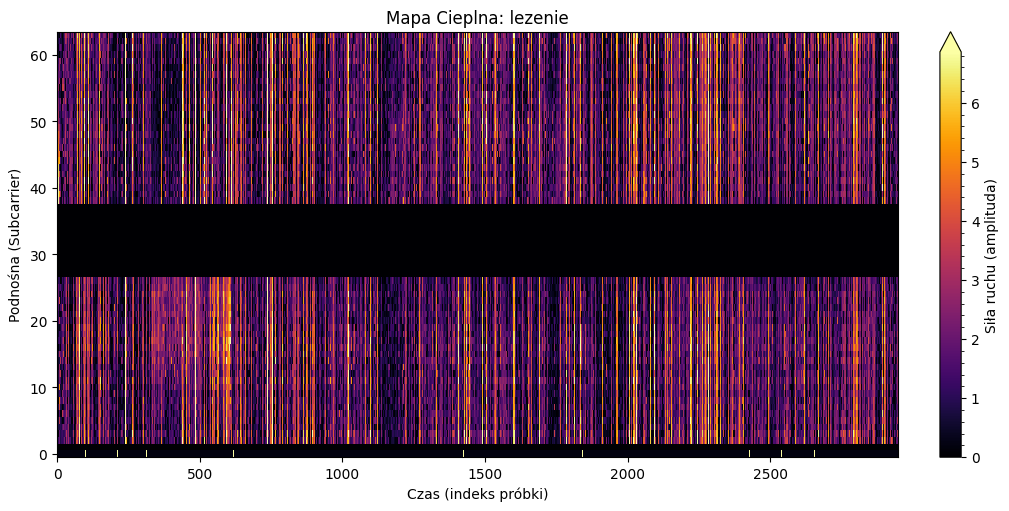

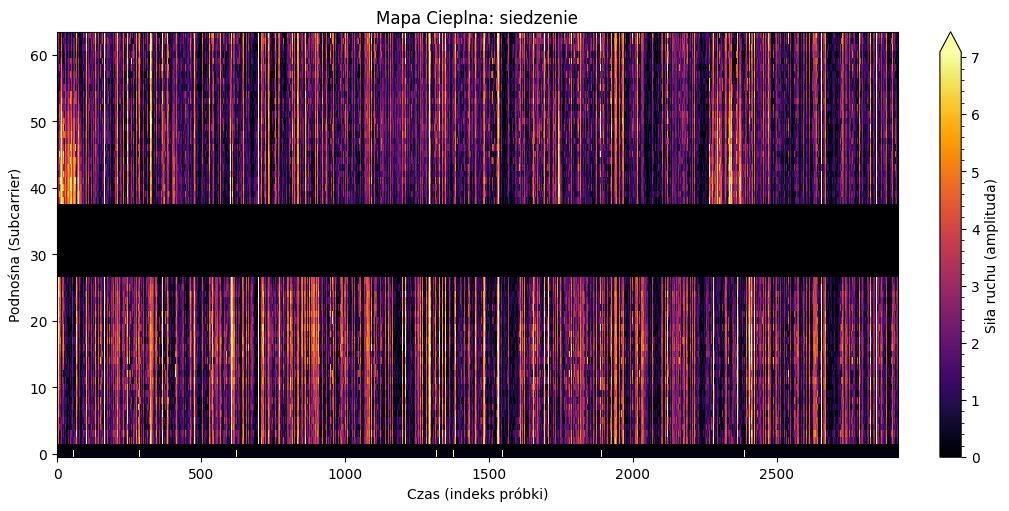

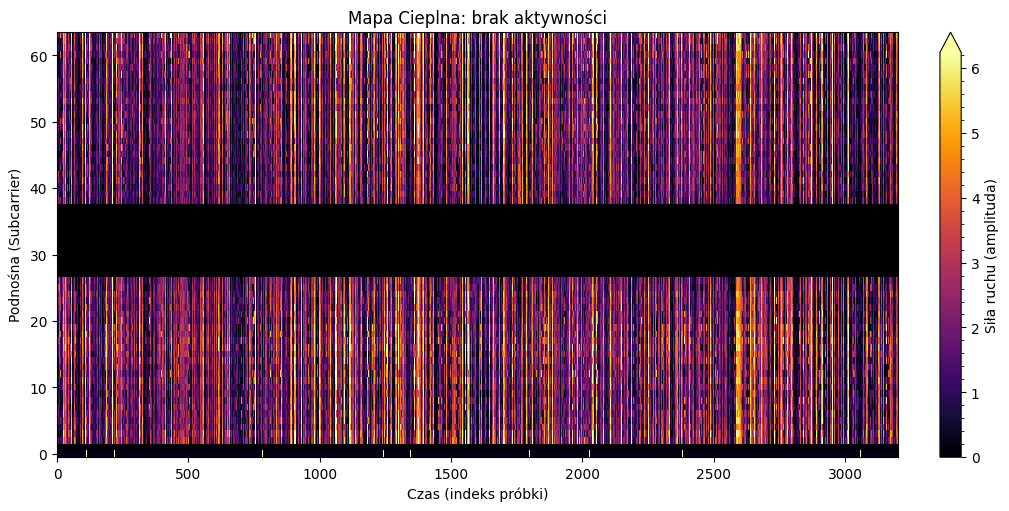

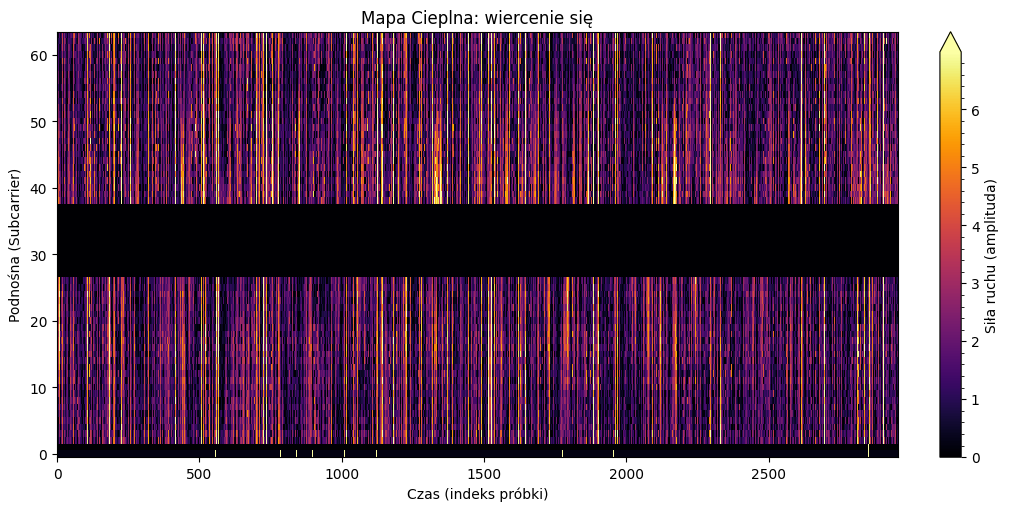

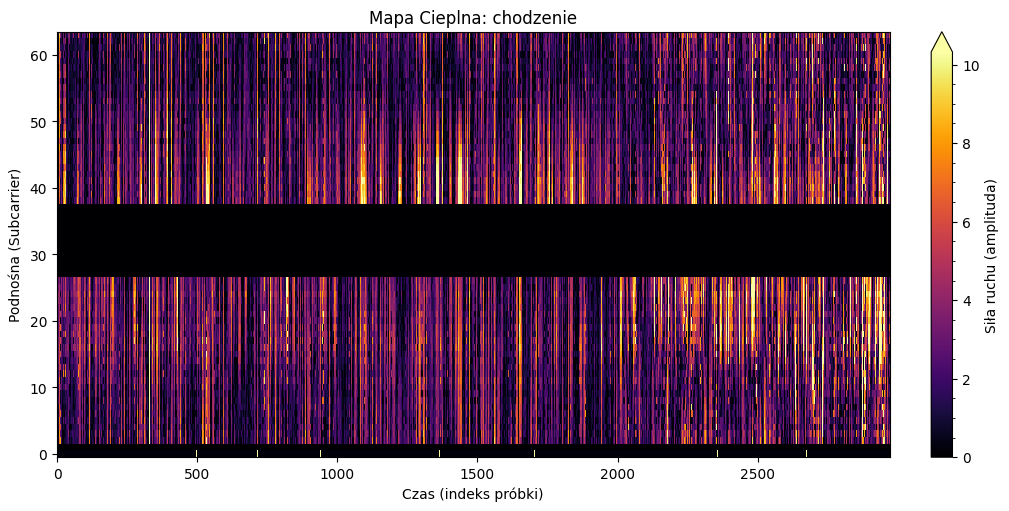

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

if 'raw_amp_dataframes' in locals() and 'label_list_files' in locals() and len(raw_amp_dataframes) > 0:

    print(f"Generowanie map (Styl Matplotlib Gallery) dla {len(raw_amp_dataframes)} plików...")

    for i in range(len(raw_amp_dataframes)):
        label = label_list_files[i]
        df_activity = raw_amp_dataframes[i]

        # --- DANE ---
        data_matrix = df_activity.T.values
        # Usuwamy tło (średnią) i bierzemy moduł, aby widzieć "energię" ruchu
        data_centered = data_matrix - np.mean(data_matrix, axis=1, keepdims=True)
        data_to_plot = np.abs(data_centered)

        # Skalowanie (odcięcie 1% pików)
        vmax = np.nanpercentile(data_to_plot, 99)
        vmin = 0

        # --- WYKRES (wg wzorca z linku) ---
        # layout='constrained' automatycznie dopasowuje marginesy
        fig, ax = plt.subplots(figsize=(10, 5), layout='constrained')

        # interpolation='none' (jak w linku) - pokazuje surowe piksele bez rozmywania
        im = ax.imshow(data_to_plot, aspect='auto', origin='lower',
                       cmap='inferno', vmin=vmin, vmax=vmax, interpolation='none')

        # Pasek kolorów z "extend", pokazujący, że skala idzie dalej
        cbar = fig.colorbar(im, ax=ax, extend='max')
        cbar.minorticks_on() # Drobne podziałki (jak w linku)
        cbar.set_label('Siła ruchu (amplituda)')

        ax.set_xlabel('Czas (indeks próbki)')
        ax.set_ylabel('Podnośna (Subcarrier)')
        ax.set_title(f'Mapa Cieplna: {label}')

        plt.show()

else:
    print("BŁĄD: Brak zmiennej 'raw_amp_dataframes'.")

Generowanie wykresów liniowych dla podnośnej nr 50...


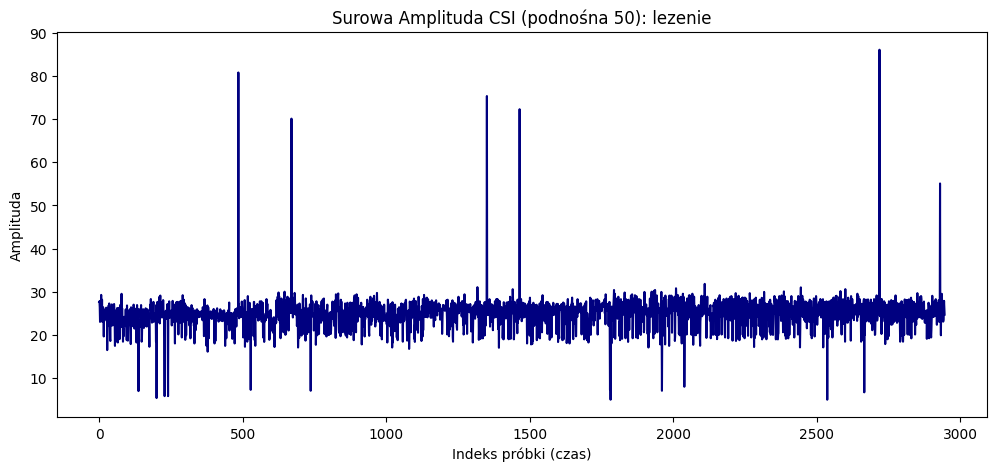

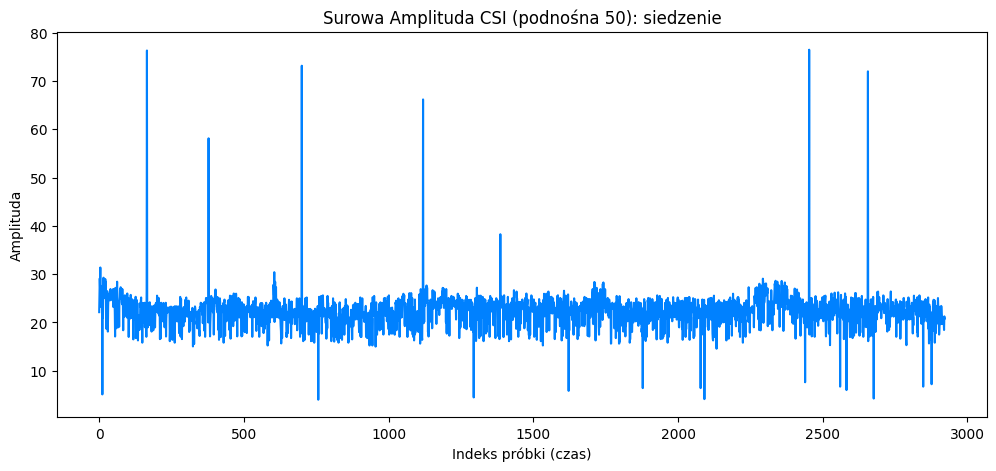

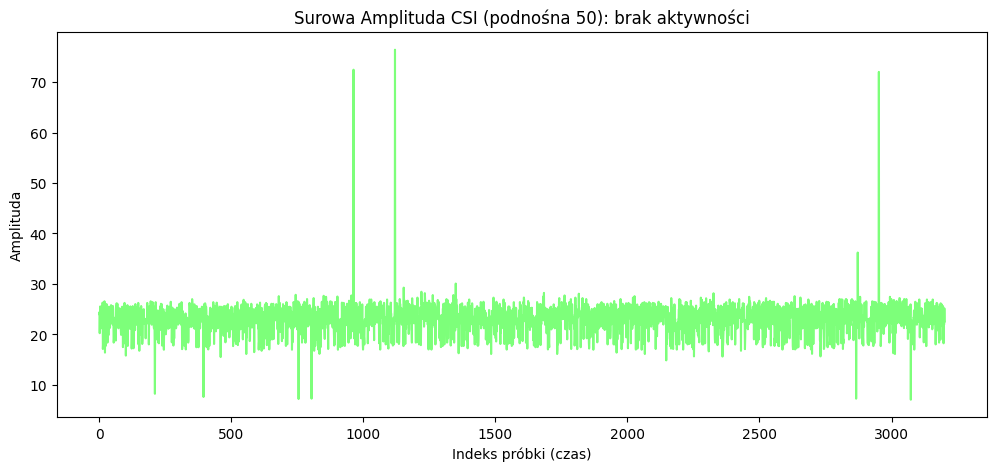

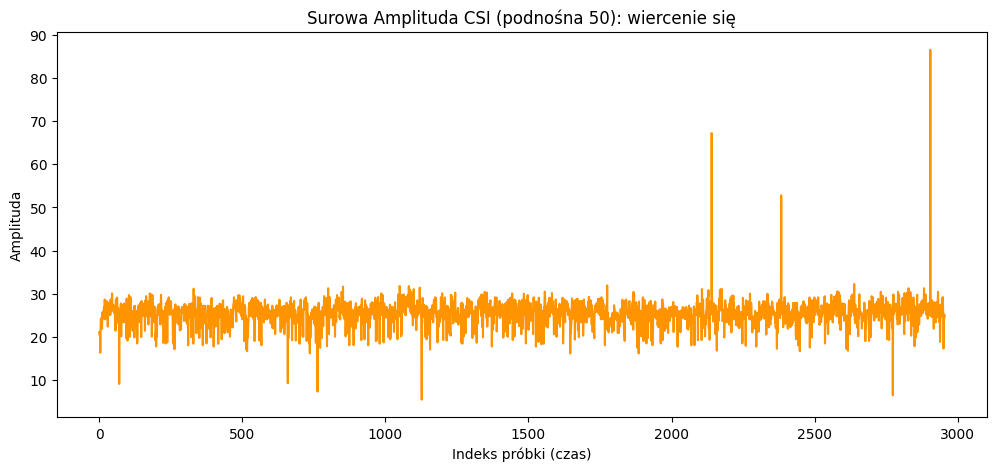

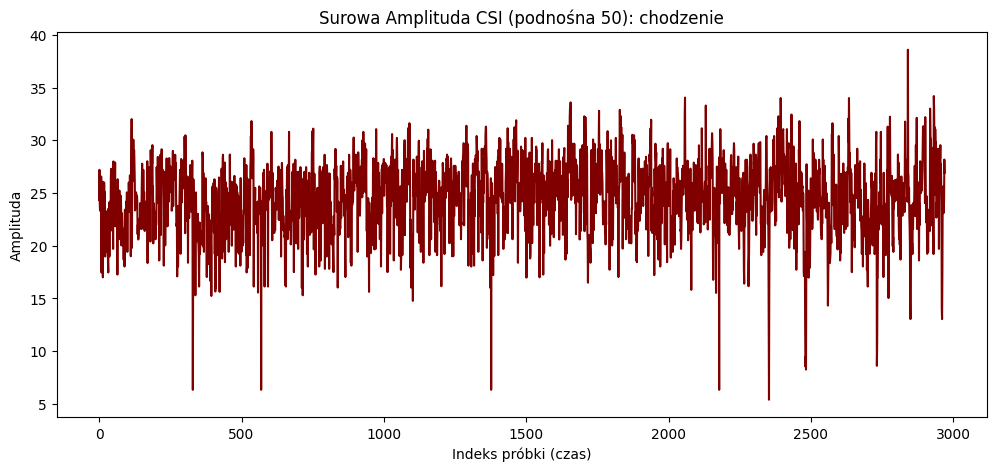

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Zmodyfikowano, aby iterować po wszystkich wczytanych DataFrames
if 'raw_amp_dataframes' in locals() and len(raw_amp_dataframes) > 0:

    subcarrier_to_plot = 50
    print(f"Generowanie wykresów liniowych dla podnośnej nr {subcarrier_to_plot}...")

    # Generowanie unikalnych kolorów dla każdego wykresu
    colors = plt.cm.jet(np.linspace(0, 1, len(raw_amp_dataframes)))

    for i in range(len(raw_amp_dataframes)):
        label = label_list_files[i]
        df_activity = raw_amp_dataframes[i]

        if subcarrier_to_plot >= df_activity.shape[1]:
            print(f"Ostrzeżenie: Kolumna {subcarrier_to_plot} nie istnieje dla '{label}'. Używam pierwszej kolumny (0).")
            subcarrier_to_plot_safe = 0
        else:
            subcarrier_to_plot_safe = subcarrier_to_plot

        plt.figure(figsize=(12, 5))
        plt.plot(df_activity[subcarrier_to_plot_safe], color=colors[i])
        plt.xlabel('Indeks próbki (czas)')
        plt.ylabel('Amplituda')
        plt.title(f'Surowa Amplituda CSI (podnośna {subcarrier_to_plot_safe}): {label}')
        plt.show()

else:
    print("BŁĄD: Zmienna 'raw_amp_dataframes' nie jest zdefiniowana.")
    print("Upewnij się, że poprzedni krok (Krok 2) został wykonany poprawnie.")


In [ ]:
import pandas as pd
import numpy as np
from hampel import hampel
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

# Sprawdzenie, czy zmienne raw_amp_dataframes istnieją
if 'raw_amp_dataframes' in locals() and len(raw_amp_dataframes) > 0:

    # Tu będziemy przechowywać przefiltrowane ramki danych
    denoised_dataframes = []

    # Logika bazuje na komórce [14] z notatnika 'Trening_GRU+CNN (1).ipynb'
    for i in range(len(raw_amp_dataframes)):
        df = raw_amp_dataframes[i]
        label = label_list_files[i] # Używamy listy etykiet plików z Kroku 2

        print(f" Filtruję dane dla: '{label}' (kształt: {df.shape})...")

        filtered_data_for_file = pd.DataFrame()

        # Iterujemy przez każdą kolumnę (podnośną)
        for col in df.columns:
            col_series = df[col].astype(float) # Upewniamy się, że dane są typu float

            # 1. Filtr Hampel (usuwa wartości odstające)
            # Używamy tych samych parametrów co w notatniku: okno 10
            hampel_filtered = hampel(col_series, window_size=10)

            # 2. Filtr Savitzky-Golay (wygładza sygnał)
            # Używamy tych samych parametrów co w notatniku: okno 10, wielomian 3
            sg_filtered = savgol_filter(hampel_filtered.filtered_data, window_length=10, polyorder=3)

            filtered_data_for_file[col] = sg_filtered

        denoised_dataframes.append(filtered_data_for_file)


    print(f"Utworzono {len(denoised_dataframes)} odszumione ramki danych.")

else:
    print("BŁĄD: Zmienna 'raw_amp_dataframes' nie jest zdefiniowana.")
    print("Upewnij się, że Krok 2 (wczytywanie i parsowanie) został wykonany poprawnie.")

 Filtruję dane dla: 'lezenie' (kształt: (2947, 64))...
 Filtruję dane dla: 'siedzenie' (kształt: (2922, 64))...
 Filtruję dane dla: 'brak aktywności' (kształt: (3202, 64))...
 Filtruję dane dla: 'wiercenie się' (kształt: (2955, 64))...
 Filtruję dane dla: 'chodzenie' (kształt: (2971, 64))...
Utworzono 5 odszumione ramki danych.


Generowanie map po filtracji (Styl Matplotlib Gallery)...


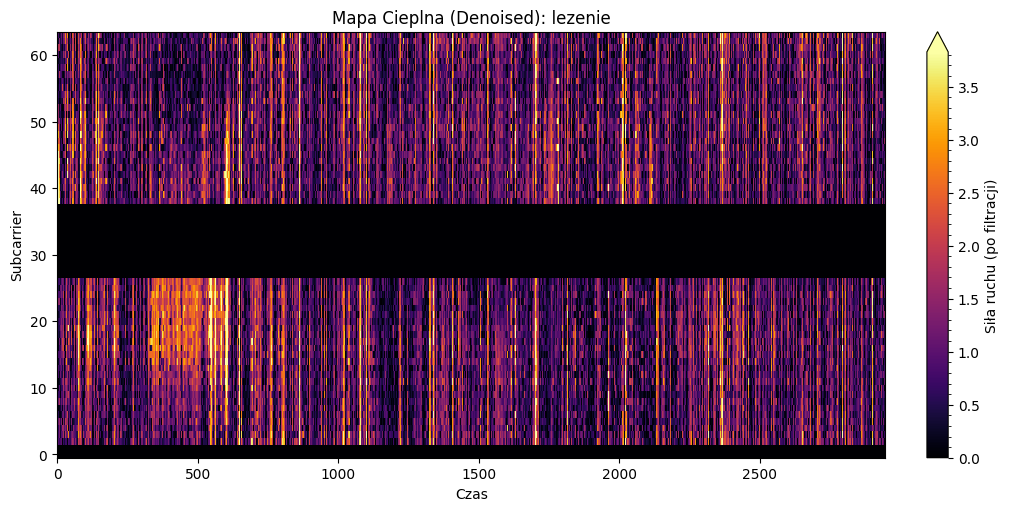

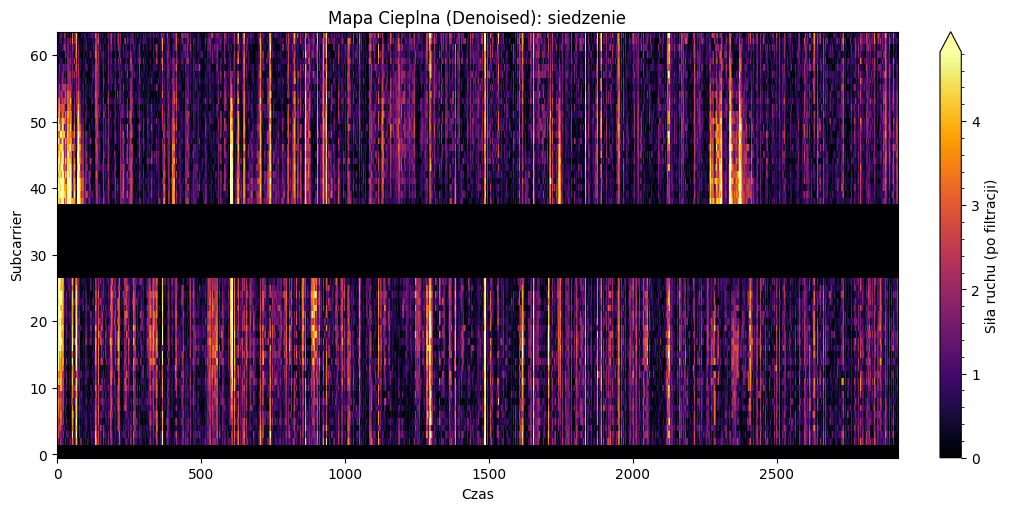

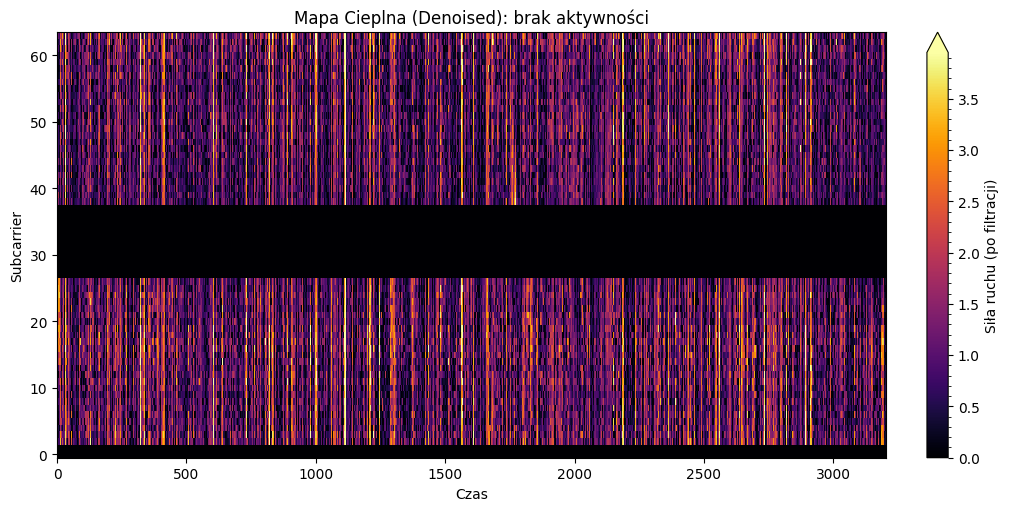

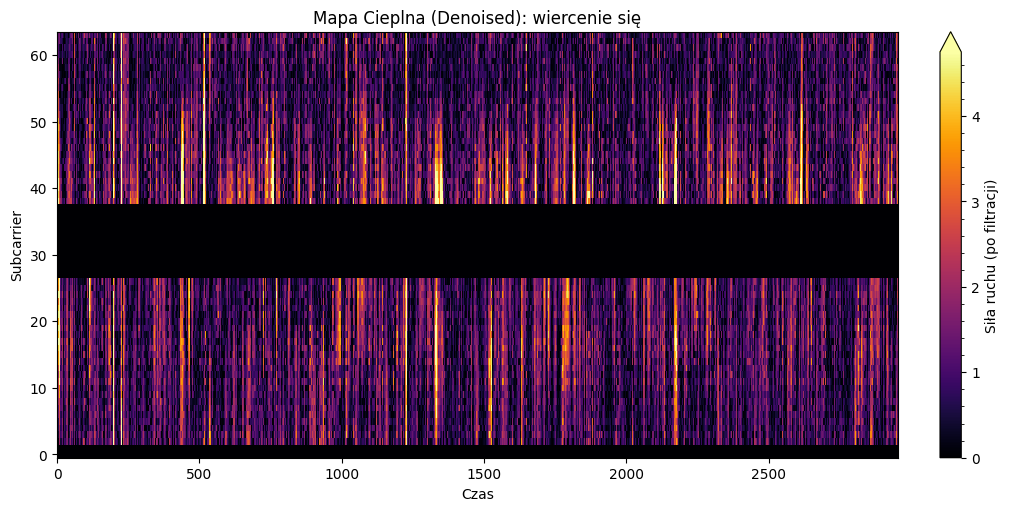

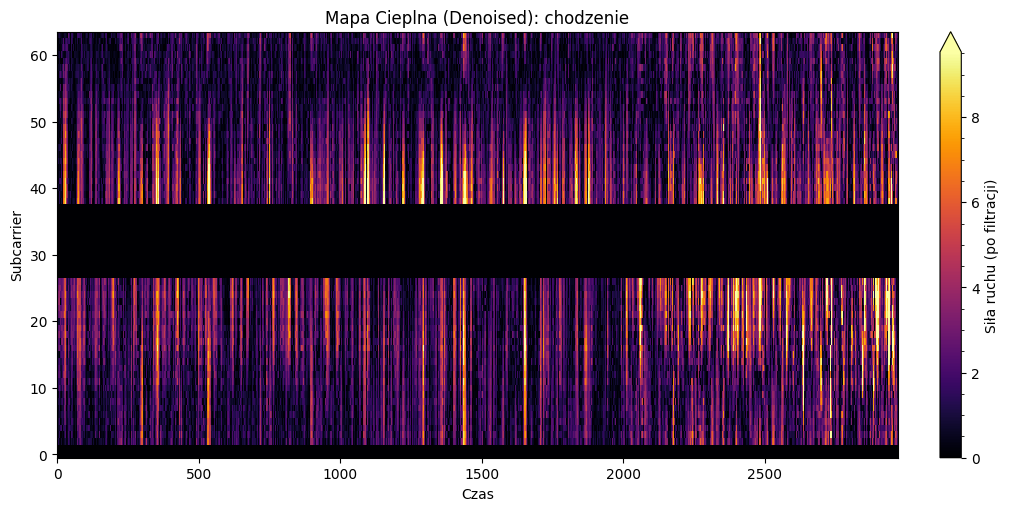

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

if 'denoised_dataframes' in locals() and 'label_list_files' in locals() and len(denoised_dataframes) == len(label_list_files):

    print(f"Generowanie map po filtracji (Styl Matplotlib Gallery)...")

    for i in range(len(denoised_dataframes)):
        label = label_list_files[i]
        df_denoised = denoised_dataframes[i]

        # --- DANE ---
        data_matrix = df_denoised.T.values
        # Usuwanie tła
        data_centered = data_matrix - np.mean(data_matrix, axis=1, keepdims=True)
        data_to_plot = np.abs(data_centered)

        # Skalowanie
        vmax = np.nanpercentile(data_to_plot, 99.5)
        vmin = 0

        # --- WYKRES ---
        fig, ax = plt.subplots(figsize=(10, 5), layout='constrained')

        # interpolation='none' dla ostrości
        im = ax.imshow(data_to_plot, aspect='auto', origin='lower',
                       cmap='inferno', vmin=vmin, vmax=vmax, interpolation='none')

        # Dodatki z linku: extend i minorticks
        cbar = fig.colorbar(im, ax=ax, extend='max')
        cbar.minorticks_on()
        cbar.set_label('Siła ruchu (po filtracji)')

        ax.set_xlabel('Czas')
        ax.set_ylabel('Subcarrier')
        ax.set_title(f'Mapa Cieplna (Denoised): {label}')

        # Zapisz
        plt.savefig(f'{label.replace(" ", "_")}_style_heatmap.png')
        plt.show()
else:
    print("BŁĄD: Brak zmiennej 'denoised_dataframes'.")

Generowanie wykresów liniowych PO FILTRACJI dla podnośnej nr 50...


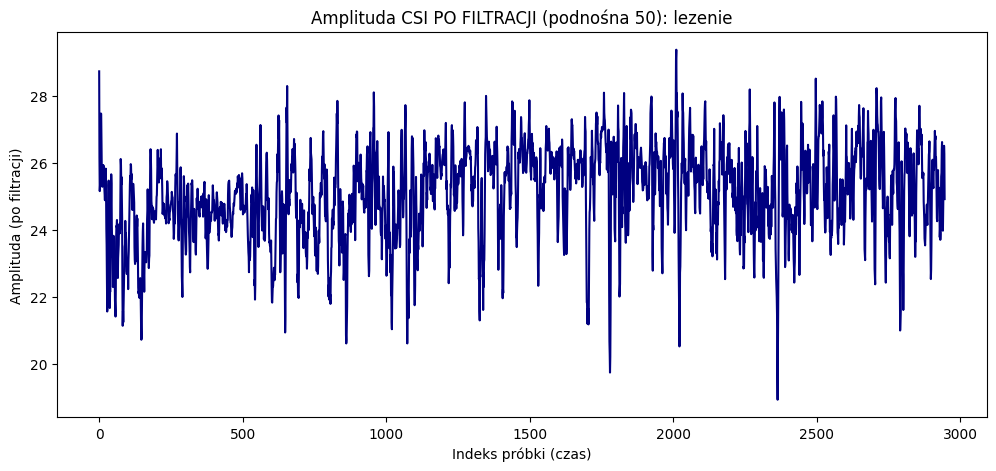

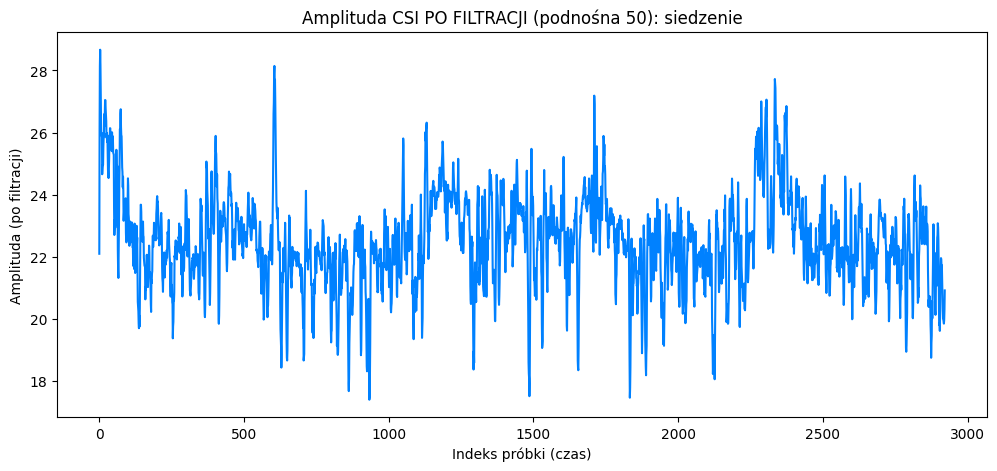

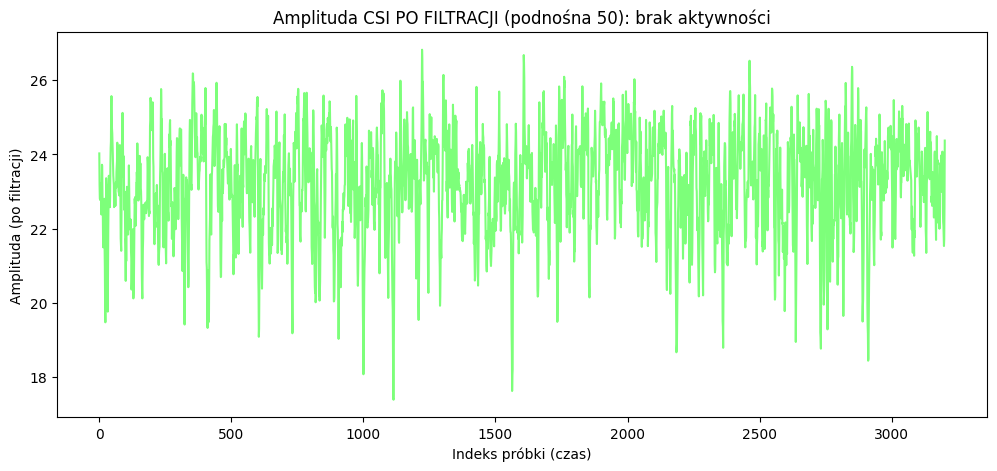

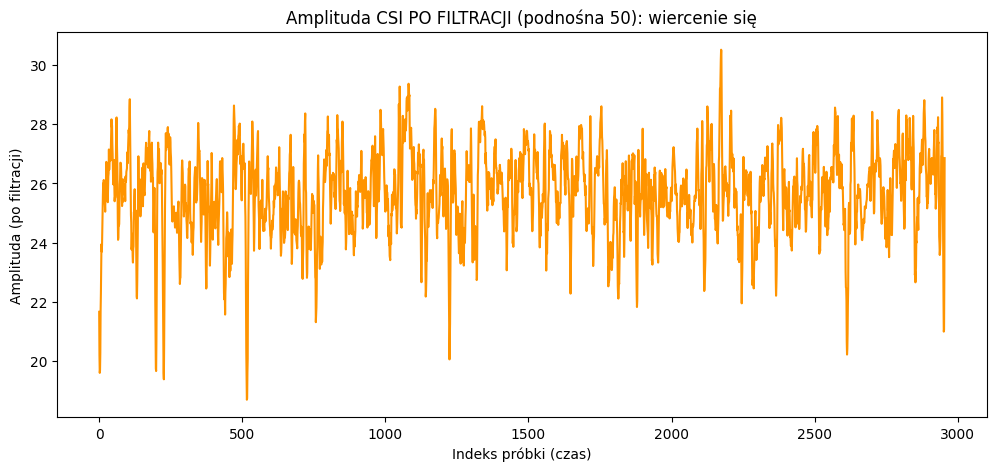

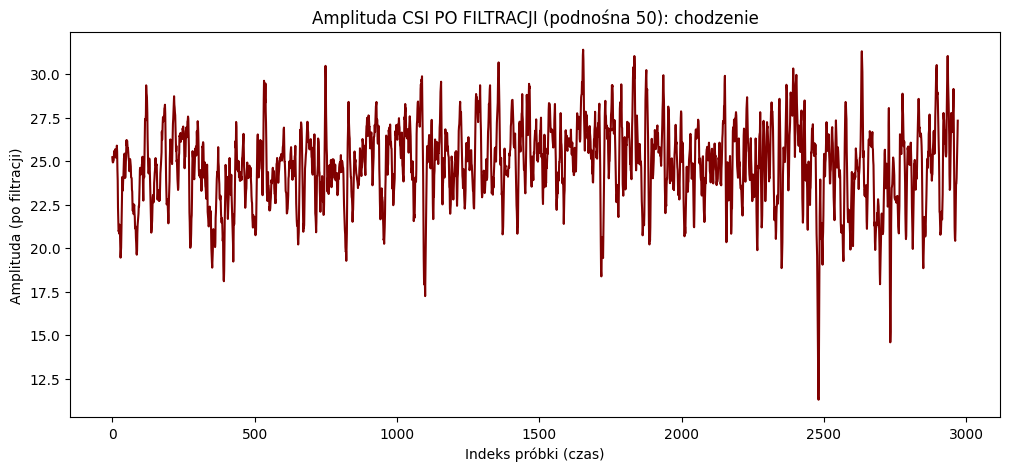

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


if 'denoised_dataframes' in locals() and 'label_list_files' in locals() and len(denoised_dataframes) > 0:

    subcarrier_to_plot = 50
    print(f"Generowanie wykresów liniowych PO FILTRACJI dla podnośnej nr {subcarrier_to_plot}...")

    # Generowanie unikalnych kolorów dla każdego wykresu
    colors = plt.cm.jet(np.linspace(0, 1, len(denoised_dataframes)))

    for i in range(len(denoised_dataframes)):
        label = label_list_files[i]
        df_activity = denoised_dataframes[i] # Używamy 'denoised_dataframes'

        if subcarrier_to_plot >= df_activity.shape[1]:
            print(f"Ostrzeżenie: Kolumna {subcarrier_to_plot} nie istnieje dla '{label}'. Używam pierwszej kolumny (0).")
            subcarrier_to_plot_safe = 0
        else:
            subcarrier_to_plot_safe = subcarrier_to_plot

        plt.figure(figsize=(12, 5))
        plt.plot(df_activity[subcarrier_to_plot_safe], color=colors[i])
        plt.xlabel('Indeks próbki (czas)')
        plt.ylabel('Amplituda (po filtracji)')
        plt.title(f'Amplituda CSI PO FILTRACJI (podnośna {subcarrier_to_plot_safe}): {label}')
        plt.show()

else:
    print("BŁĄD: Zmienna 'denoised_dataframes' nie jest zdefiniowana.")
    print("Upewnij się, że Krok filtracji został wykonany poprawnie.")


In [ ]:
columns_to_drop_indices = [2, 3, 4, 5, 32, 59, 60, 61, 62, 63]

trimmed_dataframes = [] # Nowa lista na ramki danych z 54 kolumnami

if 'denoised_dataframes' in locals() and len(denoised_dataframes) > 0:
    for df_denoised in denoised_dataframes:
        # Upewniamy się, że kolumny są indeksowane od 0, aby drop działał poprawnie
        df_copy = df_denoised.copy()
        df_copy.columns = range(df_copy.shape[1])

        # Usuwamy kolumny po ich nazwach (indeksach liczbowych)
        trimmed_df = df_copy.drop(columns=columns_to_drop_indices, axis=1)
        trimmed_dataframes.append(trimmed_df)

else:
    print("BŁĄD KROKU 5: Zmienna 'denoised_dataframes' nie jest zdefiniowana.")


#Segmentacja (Metodą Okna Przesuwnego)
# To jest zmodyfikowana wersja komórki [18] z 'CSI_full_training (10).ipynb',
# aby wygenerować więcej danych z moich krótkich plików.

segment_dataframes = [] # To będą nasze finalne dane X
labels = []             # To będą nasze finalne etykiety y

segment_length = 20  # Długość okna (jak w notatniku)
step = 5             # Krok przesunięcia okna

if 'trimmed_dataframes' in locals() and len(trimmed_dataframes) > 0:

    total_segments_generated = 0
    for i, df_trimmed in enumerate(trimmed_dataframes):
        current_label = label_list_files[i] # Pobieramy etykietę 'chodzenie' lub 'brak_aktywnosci'
        num_samples = df_trimmed.shape[0]
        segments_per_file = 0

        # Pętla tworząca zachodzące na siebie okna
        for start in range(0, num_samples - segment_length + 1, step):
            end = start + segment_length
            segment = df_trimmed.iloc[start:end]

            segment_dataframes.append(segment)
            labels.append(current_label)
            segments_per_file += 1

        print(f"Dla '{current_label}' (dł. {num_samples}) wygenerowano {segments_per_file} segmentów.")
        total_segments_generated += segments_per_file

    print(f"\nŁącznie wygenerowano {total_segments_generated} segmentów (próbek) treningowych.")
    print(f"Kształt pojedynczego segmentu: {segment_dataframes[0].shape}")

else:
    print("Zmienna 'trimmed_dataframes' nie jest zdefiniowana.")

Dla 'lezenie' (dł. 2947) wygenerowano 586 segmentów.
Dla 'siedzenie' (dł. 2922) wygenerowano 581 segmentów.
Dla 'brak aktywności' (dł. 3202) wygenerowano 637 segmentów.
Dla 'wiercenie się' (dł. 2955) wygenerowano 588 segmentów.
Dla 'chodzenie' (dł. 2971) wygenerowano 591 segmentów.

Łącznie wygenerowano 2983 segmentów (próbek) treningowych.
Kształt pojedynczego segmentu: (20, 54)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

if 'segment_dataframes' in locals() and 'labels' in locals() and len(segment_dataframes) > 0:
    X = np.array([df.values for df in segment_dataframes], dtype=np.float32)
    y_str = np.array(labels)
    n_samples, n_timesteps, n_features = X.shape
    X_reshaped = X.reshape((n_samples, n_timesteps * n_features))

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_reshaped)

    X = X_scaled.reshape((n_samples, n_timesteps, n_features))
    print(f"Zakończono standaryzację danych. Kształt X: {X.shape}")

    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y_str)
    num_classes = len(label_encoder.classes_)

    print(f" Zakodowano etykiety. Kształt y: {y.shape}")
    print(f" Znalezione klasy ({num_classes}): {list(label_encoder.classes_)}")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        random_state=42,
        stratify=y
    )
    print(f"Zbiór treningowy (X_train): {X_train.shape}")
    print(f"Zbiór treningowy (y_train): {y_train.shape}")
    print(f"Zbiór testowy (X_test):   {X_test.shape}")
    print(f"Zbiór testowy (y_test):   {y_test.shape}")


Zakończono standaryzację danych. Kształt X: (2983, 20, 54)
 Zakodowano etykiety. Kształt y: (2983,)
 Znalezione klasy (5): [np.str_('brak aktywności'), np.str_('chodzenie'), np.str_('lezenie'), np.str_('siedzenie'), np.str_('wiercenie się')]
Zbiór treningowy (X_train): (2386, 20, 54)
Zbiór treningowy (y_train): (2386,)
Zbiór testowy (X_test):   (597, 20, 54)
Zbiór testowy (y_test):   (597,)


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

if 'X_train' in locals() and 'y_train' in locals() and 'num_classes' in locals():

    n_timesteps = X_train.shape[1]
    n_features = X_train.shape[2]

    print(f"Model BiLSTM dla danych wejściowych o kształcie: (None, {n_timesteps}, {n_features})")
    print(f"Liczba klas wyjściowych: {num_classes}")

    bilstm_model = keras.Sequential([
        layers.Bidirectional(layers.LSTM(64), input_shape=(n_timesteps, n_features)),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    bilstm_model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    print("Model został pomyślnie skompilowany.")
    bilstm_model.summary()

Model BiLSTM dla danych wejściowych o kształcie: (None, 20, 54)
Liczba klas wyjściowych: 5
Model został pomyślnie skompilowany.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 128)            │        60,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,573 (240.52 KB)

 Trainable params: 61,573 (240.52 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [ ]:
print("Rozpoczynanie treningu modelu...")
if 'bilstm_model' in locals() and 'X_train' in locals():
    history = bilstm_model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=8,
        validation_split=0.2,
        callbacks=[early_stopping],
        shuffle=True
    )
    print("-"*30)
    print("Trening Zakończony!")


Rozpoczynanie treningu modelu...
Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.5223 - loss: 1.1439 - val_accuracy: 0.8033 - val_loss: 0.5572
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8093 - loss: 0.5444 - val_accuracy: 0.8075 - val_loss: 0.4428
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8406 - loss: 0.4217 - val_accuracy: 0.8473 - val_loss: 0.4129
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8919 - loss: 0.2963 - val_accuracy: 0.8808 - val_loss: 0.3316
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8978 - loss: 0.2754 - val_accuracy: 0.9100 - val_loss: 0.2477
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9370 - loss: 0.2001 - val_accuracy: 0.9205 - val_loss: 0.2618
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9410 - loss: 0.1887 - val_accuracy: 0.9142 - val_loss: 0.2310
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy:

Generowanie predykcji na zbiorze testowym (offline)...
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step

Raport Klasyfikacji (Metryki Offline):
                 precision    recall  f1-score   support

brak aktywności       0.96      1.00      0.98       128
      chodzenie       1.00      0.92      0.96       118
        lezenie       0.96      0.93      0.95       117
      siedzenie       0.95      0.97      0.96       116
  wiercenie się       0.95      0.99      0.97       118

       accuracy                           0.96       597
      macro avg       0.96      0.96      0.96       597
   weighted avg       0.96      0.96      0.96       597


Generowanie Macierzy Pomyłek...


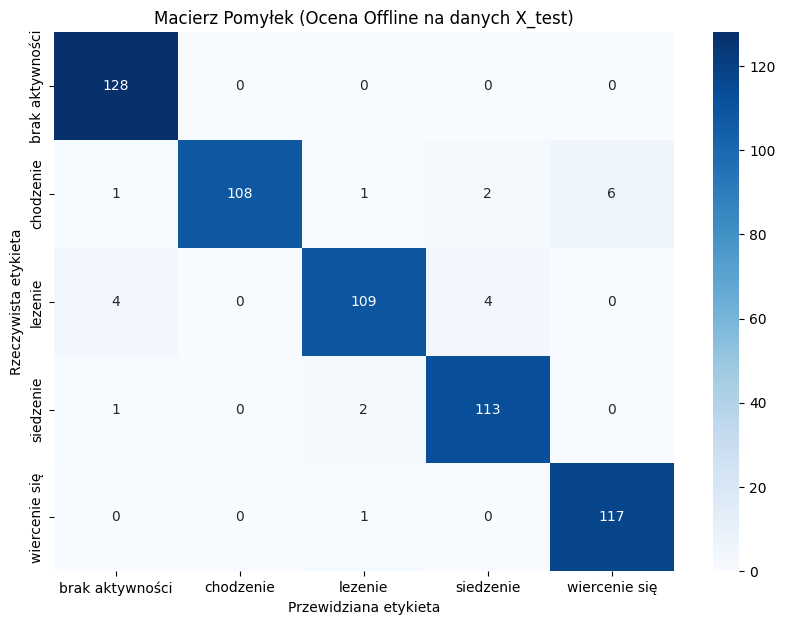

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. ZNAJDŹ I PODMIEŃ NAZWY PONIŻEJ ---

# W notatniku znajdź nazwę zmiennej, która przechowuje wytrenowany model
# (np. ta, na której wywołujesz .fit() lub .summary())
NAZWA_TWOJEGO_MODELU = bilstm_model # PRZYKŁAD: podmień 'bilstm_model' na swoją nazwę

# Znajdź zmienne ze zbioru testowego (z komórki train_test_split)
NAZWA_TWOJEGO_X_TEST = X_test # PRZYKŁAD: podmień 'X_test' na swoją nazwę
NAZWA_TWOJEGO_Y_TEST = y_test # PRZYKŁAD: podmień 'y_test' na swoją nazwę

# Znajdź nazwę zmiennej LabelEncoder (tam gdzie robiłaś fit_transform na etykietach)
NAZWA_TWOJEGO_ENCODERA = label_encoder # PRZYKŁAD: podmień 'label_encoder' na swoją nazwę

# --- 2. DALEJ NIE ZMIENIAJ NICZEGO ---

# Używamy teraz Twoich nazw zmiennych
try:
    print("Generowanie predykcji na zbiorze testowym (offline)...")

    y_pred_probs = NAZWA_TWOJEGO_MODELU.predict(NAZWA_TWOJEGO_X_TEST)

    y_pred = np.argmax(y_pred_probs, axis=1)

    # --- 1. RAPORT KLASYFIKACJI (Metryki) ---
    print("\nRaport Klasyfikacji (Metryki Offline):")
    print(classification_report(NAZWA_TWOJEGO_Y_TEST, y_pred, target_names=NAZWA_TWOJEGO_ENCODERA.classes_))


    # --- 2. MACIERZ POMYŁEK (Wykres) ---
    print("\nGenerowanie Macierzy Pomyłek...")
    cm = confusion_matrix(NAZWA_TWOJEGO_Y_TEST, y_pred)
    cm_df = pd.DataFrame(cm, index=NAZWA_TWOJEGO_ENCODERA.classes_, columns=NAZWA_TWOJEGO_ENCODERA.classes_)

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues')
    plt.title('Macierz Pomyłek (Ocena Offline na danych X_test)')
    plt.ylabel('Rzeczywista etykieta')
    plt.xlabel('Przewidziana etykieta')
    plt.show()

except NameError:
    print("\nBŁĄD: Jedna z nazw (NAZWA_TWOJEGO_MODELU, ...X_TEST, ...Y_TEST, ...ENCODERA) jest wciąż niepoprawna.")
    print("Sprawdź dokładnie nazwy zmiennych w poprzednich komórkach notatnika.")
except Exception as e:
    print(f"\nWystąpił nieoczekiwany błąd: {e}")

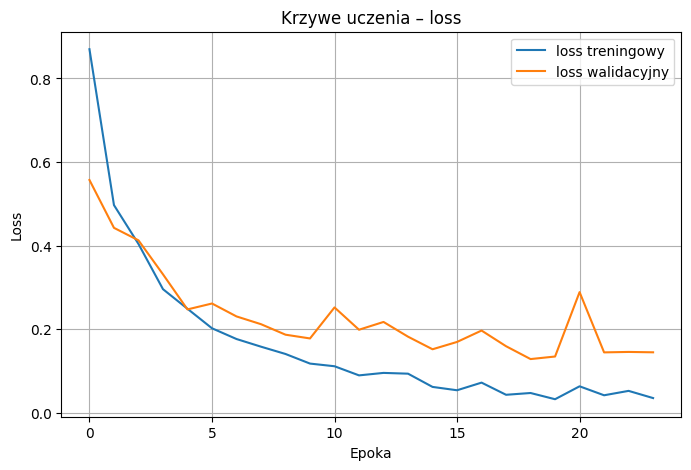

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='loss treningowy')
plt.plot(history.history['val_loss'], label='loss walidacyjny')
plt.xlabel('Epoka')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Krzywe uczenia – loss')
plt.show()


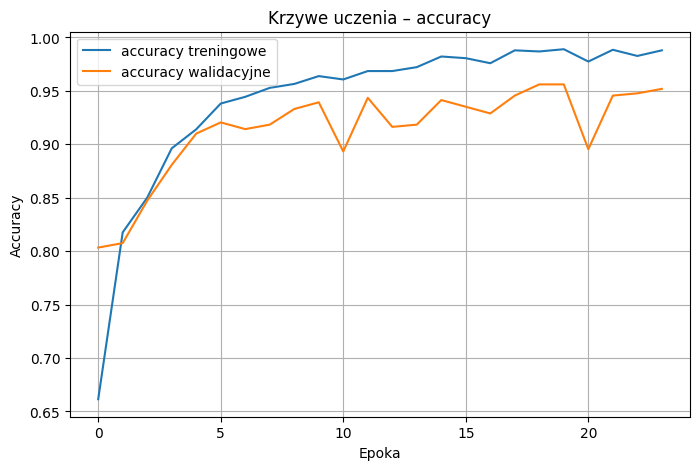

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='accuracy treningowe')
plt.plot(history.history['val_accuracy'], label='accuracy walidacyjne')
plt.xlabel('Epoka')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.title('Krzywe uczenia – accuracy')
plt.show()


In [ ]:
import tensorflow as tf

# Sprawdźmy, czy model 'bilstm_model' istnieje
if 'bilstm_model' in locals():
    model_filename = 'bilstm_model_5ak1.keras' # 2ak = 2 aktywności
    print(f"Zapisywanie wytrenowanego modelu BiLSTM jako: {model_filename}...")

    # Zapisujemy model
    bilstm_model.save(model_filename)

    print(f"Model pomyślnie zapisany.")
else:
    print("BŁĄD: Model 'bilstm_model' nie został jeszcze wytrenowany.")
    print("Upewnij się, że Krok 8 (definicja i kompilacja modelu) został wykonany.")

Zapisywanie wytrenowanego modelu BiLSTM jako: bilstm_model_5ak1.keras...
Model pomyślnie zapisany.


In [ ]:
import joblib

# Sprawdźmy, czy 'scaler' i 'label_encoder' istnieją
if 'scaler' in locals() and 'label_encoder' in locals():

    # ZMIANA: Nowa nazwa pliku dla modelu 5-aktywności
    scaler_filename = 'bilstm_scaler_5ak1.pkl' # Możesz wpisać dowolną nazwę
    print(f"Zapisywanie obiektu StandardScaler jako: {scaler_filename}...")

    # Zapisujemy scaler
    joblib.dump(scaler, scaler_filename)

    print(f"Scaler pomyślnie zapisany.")

    # --- ZMIANA TUTAJ: Pętla do wydrukowania wszystkich 5 klas ---
    print("\nKolejność klas (do skopiowania do skryptu 'na żywo'):")

    for i, class_name in enumerate(label_encoder.classes_):
        print(f"Klasa {i} = {class_name}")
    # --- Koniec Zmiany ---

else:
    print("BŁĄD: Zmienna 'scaler' lub 'label_encoder' nie została znaleziona.")
    print("Upewnij się, że Krok 7 (Standaryzacja i Podział) został wykonany poprawnie.")

Zapisywanie obiektu StandardScaler jako: bilstm_scaler_5ak1.pkl...
Scaler pomyślnie zapisany.

Kolejność klas (do skopiowania do skryptu 'na żywo'):
Klasa 0 = brak aktywności
Klasa 1 = chodzenie
Klasa 2 = lezenie
Klasa 3 = siedzenie
Klasa 4 = wiercenie się
